In [1]:
!pip install geojson
!pip install descartes
!pip install geopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd
import json
import geojson
from descartes import PolygonPatch
import geopy.distance
import imageio

In [3]:
with open("russia.json") as f:
    gj = geojson.load(f)
russia_map = gj

In [4]:
df = pd.read_csv("city.csv")
#df.nlargest(30, "population")
df = df[["address", "city", "population", "geo_lat", "geo_lon"]]
df = df.nlargest(30, "population").reset_index(drop=True)
df["city"] = df.apply(lambda x: x["address"].split()[-1] if pd.isna(x["city"]) else x["city"], axis=1)
df = df.drop("address", axis=1)
df

,city,population,geo_lat,geo_lon
0,Москва,11514330,55.754047,37.620405
1,Санкт-Петербург,4848742,59.939131,30.315900
2,Новосибирск,1498921,55.028191,82.921149
3,Екатеринбург,1377738,56.838522,60.605491
4,Нижний Новгород,1250615,56.324063,44.005391
5,Казань,1216965,55.794358,49.111497
6,Самара,1164900,53.195031,50.106952
7,Омск,1154000,54.984857,73.367452
8,Челябинск,1130273,55.160262,61.400808
9,Ростов-на-Дону,1091544,47.222457,39.718803


In [5]:
def travel_dist(path): # path: list[lat, lon] -> int. Energy for SA. Calculate total travel distance for path in kilometers
    total_dist = geopy.distance.geodesic(path[0], path[-1]).km
    for idx, _ in enumerate(path[:-1]):
        total_dist += geopy.distance.geodesic(path[idx], path[idx+1]).km
    return total_dist

In [6]:
def p_sales(path, temp): # path: list[lat, lon], temp: int -> int. Energy distribution with temperature
    return np.exp(-travel_dist(path)/temp)

In [7]:
def proporsal_dist(city_names, path): # Proporsal distribution. Randomly swap 2 cities in path
    swap_a, swap_b = np.random.choice(len(city_names), 2)
    city_names[swap_a], city_names[swap_b] = city_names[swap_b], city_names[swap_a]
    path[swap_a], path[swap_b] = path[swap_b], path[swap_a]
    return city_names, path

In [8]:
def simulated_anneling(x_0, init_temp, cold_temp, energy_func, proporsal_dist_func, temp_decrease_ratio=0.99):
    #assert temp_decrease_ratio < 1, "Temperature decrease ratio must be less than 1"
    #assert temp_decrease_ratio > 0, "Temperature decrease ratio must be more than 0"
    #assert cold_temp > 0, "Temperature to stop must be more than 0"

    log = []
    names, path = x_0
    log.append((names, path, init_temp))
    temp = init_temp

    t = 0
    while temp > cold_temp:
        names_new, path_new = proporsal_dist_func(names.copy(), path.copy())
        acceptance_ratio =  energy_func(path_new, temp)  / energy_func(path, temp) 
        #print(f"t_dist: {travel_dist(path)}")
        #print(f"temp: {temp}")
        #print(f"a_ratio: {acceptance_ratio}")
        u = np.random.uniform(0, 1)

        if u <= acceptance_ratio:
            names = names_new.copy()
            path = path_new.copy()

        log.append((names, path, temp))
        t += 1
        if t == 2:
            temp = temp * temp_decrease_ratio
            t = 0
    return log

In [9]:
lat = list(df['geo_lat'])
lon = list(df['geo_lon'])
names = list(df['city'])

path = list(zip(lat, lon))
x0 = (names, path)
log = simulated_anneling(x0, 40000, 20, p_sales, proporsal_dist, temp_decrease_ratio=0.95)

<ipython-input-8-4bb7ee4cd636>:14: RuntimeWarning: invalid value encountered in double_scalars
  acceptance_ratio =  energy_func(path_new, temp)  / energy_func(path, temp)


In [10]:
len(log)

299

<Figure size 640x480 with 0 Axes>

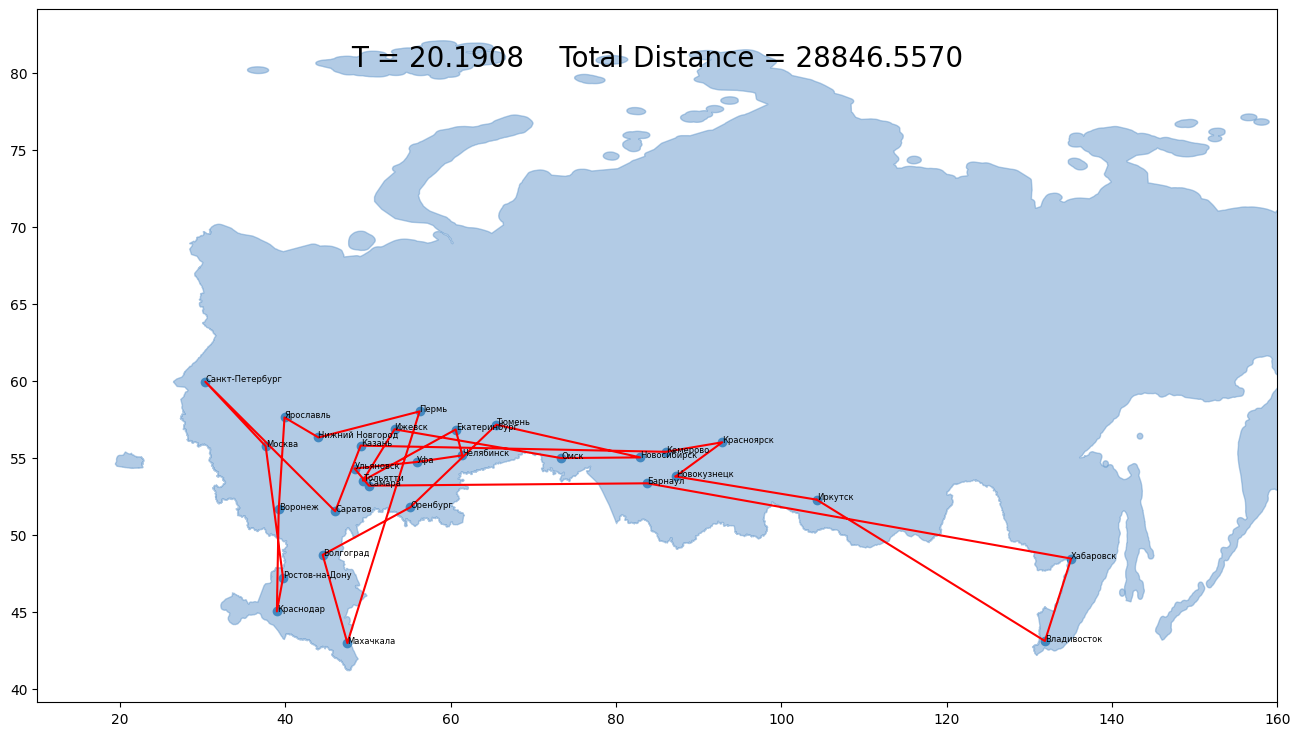

In [11]:
plt.clf()
x = df['geo_lon']
y = df['geo_lat']

text = df['city']

BLUE = '#6699cc'

fig = plt.figure(figsize=(16, 9)) 
ax = fig.gca()

for coords in russia_map[0]['geojson']['coordinates']:
    if coords[0][0][0] < 0:
        continue
    poly = {"type": "Polygon", "coordinates": coords}
    ax.add_patch(PolygonPatch(poly, fc=BLUE, ec=BLUE, alpha=0.5, zorder=2))

ax.scatter(x, y)

for i, txt in enumerate(text):
    ax.annotate(txt, (x[i], y[i]), fontsize=6)

final_path = log[-1][1]
ax.plot([final_path[0][1], final_path[-1][1]], [final_path[0][0], final_path[-1][0]], color='red')
ax.plot([x[1] for x in final_path], [x[0] for x in final_path], color='red')
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

ax.text(0.5 * (left + right), 0.95, f'T = {log[-1][2]:0.4f}    Total Distance = {travel_dist(log[-1][1]):0.4f}',
        horizontalalignment='center',
        verticalalignment='top',
        transform=ax.transAxes, fontsize=20)
plt.xlim((10, 160))
#plt.ylim((39, 65))
#ax.set_aspect('equal')
#ax.axis('scaled')
plt.show()

In [12]:
#log = log[::10]

<Figure size 640x480 with 0 Axes>

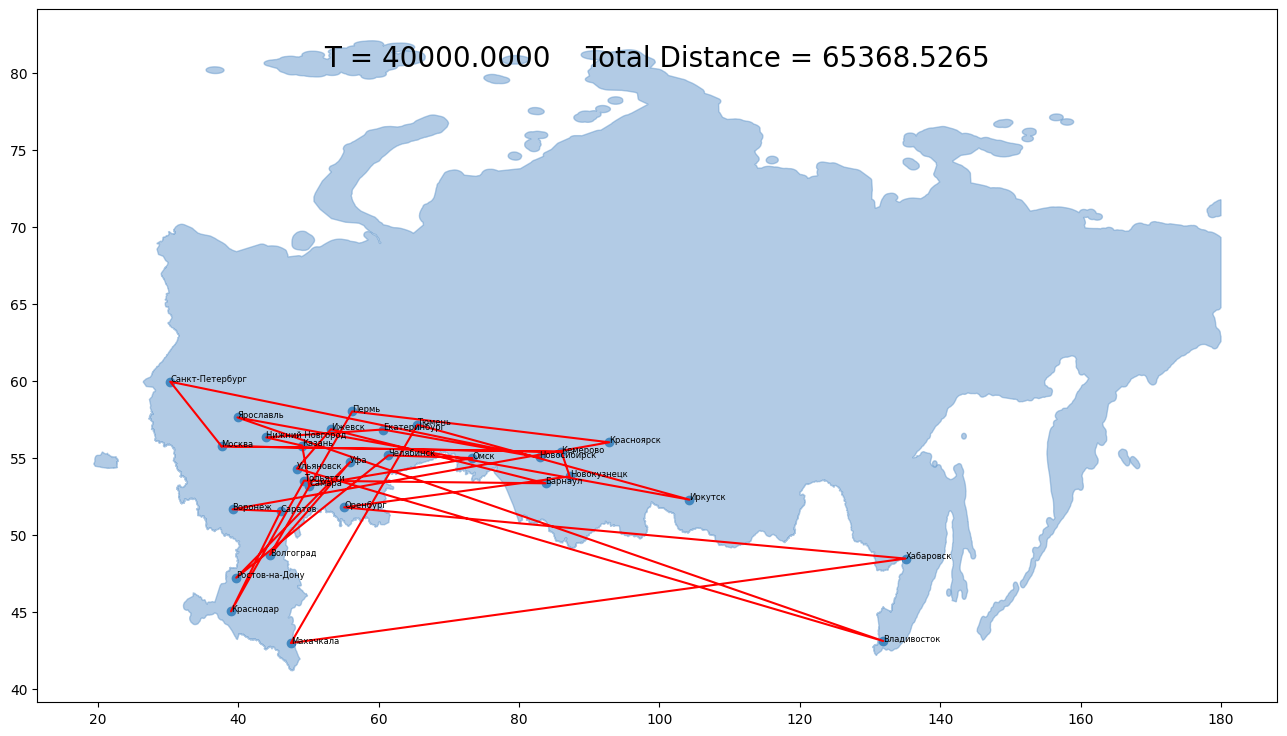

In [13]:
from matplotlib.animation import FuncAnimation

plt.clf()

x = df['geo_lon']
y = df['geo_lat']
text = df['city']
BLUE = '#6699cc'
fig = plt.figure(figsize=(16, 9)) 
ax = fig.gca() 
for coords in russia_map[0]['geojson']['coordinates']:
    if coords[0][0][0] < 0:
        continue
    poly = {"type": "Polygon", "coordinates": coords}
    ax.add_patch(PolygonPatch(poly, fc=BLUE, ec=BLUE, alpha=0.5, zorder=2))
ax.scatter(x, y)
for i, txt in enumerate(text):
    ax.annotate(txt, (x[i], y[i]), fontsize=6)

line, = ax.plot([], [], color='red')
label = ax.text(0.5 * (left + right), 0.95, "",
            horizontalalignment='center',
            verticalalignment='top',
            transform=ax.transAxes, fontsize=20)


def update(i):
    path = log[i][1]
    x = [x[1] for x in path]
    y = [x[0] for x in path]
    x.append(path[0][1])
    x.append(path[-1][1])
    y.append(path[0][0])
    y.append(path[-1][0])
    line.set_data(x, y)

    left, width = .25, .5
    bottom, height = .25, .5
    right = left + width
    top = bottom + height
    label.set_text(f'T = {log[i][2]:0.4f}    Total Distance = {travel_dist(log[i][1]):0.4f}')

ani = FuncAnimation(fig, update, 
                    frames=len(log), interval=100)

In [14]:
from IPython.display import HTML
HTML(ani.to_html5_video())